In [0]:
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.layers import Dense,Activation,Dropout,Flatten,LSTM,Input,Bidirectional
from keras.optimizers import RMSprop,SGD,Adam
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.models import load_model
from keras.models import Model
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle
import numpy as np
import re
import nltk


nltk.download('stopwords')
nltk.download('punkt')
!pip install jsonlines


import jsonlines

stop_words = set(stopwords.words('english'))
pst=PorterStemmer()

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Preprocessing on text

In [0]:
def text_clean(text):
  text=text.lower()
  texty=word_tokenize(text)
  texty=[word for word in texty if not word in stop_words]
  for i in range(len(texty)):
    texty[i]=pst.stem(texty[i])
  sen = (" ").join(texty)
  sen=re.sub('[^a-zA-Z]',' ', sen)
  sen = re.sub(r"\s+[a-zA-Z]\s+",' ', sen)
  sen = re.sub(r'\s+', ' ', sen)
  #stop_tokens=[word for words in ]
  return str(sen)

In [0]:
chstr=text_clean('A dark-haired drummer is playing his set with enthusiasm.')
print(chstr)
print(word_tokenize(chstr))

dark hair drummer play set enthusiasm 
['dark', 'hair', 'drummer', 'play', 'set', 'enthusiasm']


Reading data from SNLI dataset

In [0]:
s1,s2,label=[],[],[]
Labels = ['contradiction','neutral','entailment','-']
def data_read(): 
  s1.clear()
  s2.clear()
  label.clear()
  str_dev='/content/drive/My Drive/Colab Notebooks/Datasets/proj3/snli_1.0_dev.jsonl'
  str_train='/content/drive/My Drive/Colab Notebooks/Datasets/proj3/snli_1.0_train.jsonl'
    
  with jsonlines.open(str_train) as td:
    for line in td.iter():
      #print(line['sentence1']+'\n',line['sentence2']+'\n',line['gold_label'])
      s1.append(text_clean(line['sentence1']))
      s2.append(text_clean(line['sentence2']))
      label.append(Labels.index(line['gold_label'].lower()))
      #label.append(line['gold_label'].lower())
data_read()
label=np.array(label)   

In [0]:
word_s1 = lambda s1: len(word_tokenize(s1))
word_s2 = lambda s2: len(word_tokenize(s2))
print(len(max(s1, key=word_s1)))
print(len(max(s1, key=word_s2)))

241
241


In [0]:
for i in range(606,609):
  print(s1[i],"   ",s2[i])
  print(label[i])
print(len(s1),len(label))

three guy girl jump pool togeth      peopl climb water 
0
three guy girl jump pool togeth      peopl jump bodi water 
2
three guy girl jump pool togeth      peopl friend 
1
550152 550152


Preparing data for training and validation

In [0]:
max_seq=35
max_word_keep=180000
valid_split=0.07

In [0]:
tokens=Tokenizer(num_words=max_word_keep)
tokens.fit_on_texts(s1+s2)
voc_size = len(tokens.word_index) + 1
seq1=tokens.texts_to_sequences(s1)
seq2=tokens.texts_to_sequences(s2)
xs1=pad_sequences(seq1,maxlen=max_seq)
xs2=pad_sequences(seq2,maxlen=max_seq)

In [0]:
pickle.dump(tokens, open("tokens_180.lstm", "wb"))

In [0]:
word_s1 = lambda s1: len(seq1)
word_s2 = lambda s2: len(seq2)
print(len(max(seq1, key=word_s1)))
print(len(max(seq2, key=word_s2)))
print(xs1.shape)
print(voc_size)

5
4
(550152, 35)
21871


In [0]:
permute = np.random.permutation(len(xs1))
#print(perm)
amount=int(len(xs1)*(1-valid_split))
print(amount)
train_id=permute[:amount]
val_id=permute[amount:]
#print(train_id)
xs1_train=xs1[train_id]
xs1_val=xs1[val_id]
xs2_train=xs2[train_id]
xs2_val=xs2[val_id]
ytrain=label[train_id]
yval=label[val_id]

511641


Embeddings matrix generation

In [0]:
embed=dict()
glove_100='/content/drive/My Drive/Colab Notebooks/Library/glove.6B.100d.txt'
glove_300='/content/drive/My Drive/Colab Notebooks/Library/glove.6B.300d.txt'
dim=300
glove=open(glove_300,encoding="utf8")
for line in glove:
    rows = line.split()
    word = rows[0]
    vec = np.asarray(rows[1:], dtype='float32')
    embed[word] = vec
glove.close()

In [0]:
embed_mat = np.zeros((voc_size, dim))
for word, i in tokens.word_index.items():
    embed_vec = embed.get(word)
    if embed_vec is not None:
        embed_mat[i] = embed_vec

Training model

In [0]:
print(xs1_train.shape)
print(ytrain.shape)
print(embed_mat.shape)
print(voc_size)

(511641, 35)
(511641,)
(21871, 300)
21871


In [0]:
def lstm_model(embed_mat,out_class,num_dense):
  s1_input=Input(shape=(max_seq,),dtype='int32')
  s2_input=Input(shape=(max_seq,),dtype='int32')

  input_dim,output_dim=embed_mat.shape
  embed=Embedding(input_dim,output_dim,weights=[embed_mat],trainable=False)
  embed_s1=embed(s1_input)
  embed_s2=embed(s2_input)
  first_drop=0.22
  rec_drop=0.178
  lstm=LSTM(num_dense, dropout=rec_drop, recurrent_dropout=rec_drop)
  
  f1=lstm(embed_s1)
  f2=lstm(embed_s2)

  sumx=concatenate([f1, f2])
  sumx=Dropout(first_drop)(sumx)
  sumx=BatchNormalization()(sumx)
  sumx=Dense(num_dense,activation='relu')(sumx)
  sumx=Dropout(first_drop)(sumx)
  sumx=BatchNormalization()(sumx)
  
 
  pred=Dense(out_class,activation='softmax')(sumx)
  model = Model(inputs=[s1_input,s2_input],outputs=pred)
  return model

In [0]:
num_class=len(Labels)
num_epoch=60
batch_size=1024
num_dense=312
ytrain_arr=to_categorical(ytrain,num_class)
yval_arr=to_categorical(yval,num_class)

model=lstm_model(embed_mat=embed_mat,out_class=num_class,num_dense=num_dense)
opt=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 300)      6561300     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 312)          765024      embedding_4[0][0]          

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history=model.fit([xs1_train, xs2_train],ytrain_arr,validation_data=([xs1_val, xs2_val],yval_arr),epochs=num_epoch,batch_size=batch_size,verbose=1,callbacks=[early_stop])
model.save('lstm_312_keep.h5')

Train on 511641 samples, validate on 38511 samples
Epoch 1/60
511641/511641 [==============================] - 92s 180us/step - loss: 0.9624 - acc: 0.5669 - val_loss: 0.7991 - val_acc: 0.6497
Epoch 2/60
511641/511641 [==============================] - 92s 180us/step - loss: 0.8080 - acc: 0.6433 - val_loss: 0.7587 - val_acc: 0.6712
Epoch 3/60
511641/511641 [==============================] - 92s 180us/step - loss: 0.7607 - acc: 0.6712 - val_loss: 0.7233 - val_acc: 0.6908
Epoch 4/60
511641/511641 [==============================] - 93s 182us/step - loss: 0.7325 - acc: 0.6857 - val_loss: 0.6978 - val_acc: 0.7062
Epoch 5/60
511641/511641 [==============================] - 95s 186us/step - loss: 0.7123 - acc: 0.6978 - val_loss: 0.6899 - val_acc: 0.7089
Epoch 6/60
511641/511641 [==============================] - 96s 188us/step - loss: 0.6952 - acc: 0.7072 - val_loss: 0.6795 - val_acc: 0.7158
Epoch 7/60
511641/511641 [==============================] - 96s 188us/step - loss: 0.6807 - acc: 0.7147

In [0]:
def plotting(history,name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch '+str(num_epoch))
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig(name)
    plt.show()

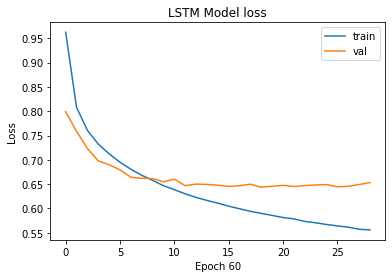

In [0]:
plotting(history,"lstm_plot_312_keep.png")

Testing the model on test set

In [0]:
str_model='lstm_312_keep.h5'
model_test=load_model(str_model)

In [0]:
tokens=tokens=pickle.load(open('tokens.lstm','rb'))

In [0]:
str_test='/content/drive/My Drive/Colab Notebooks/Datasets/proj3/snli_1.0_test.jsonl'
Labels = ['contradiction','neutral','entailment','-']
s1_test,s2_test,label_test=[],[],[]
with jsonlines.open(str_test) as td:
    for line in td.iter():
      #print(line['sentence1']+'\n',line['sentence2']+'\n',line['gold_label'])
      s1_test.append(text_clean(line['sentence1']))
      s2_test.append(text_clean(line['sentence2']))
      label_test.append(Labels.index(line['gold_label'].lower()))
      #label.append(line['gold_label'].lower())
label_test=np.array(label_test)   

In [0]:
seq1_test=tokens.texts_to_sequences(s1_test)
seq2_test=tokens.texts_to_sequences(s2_test)
xs1_test=pad_sequences(seq1_test,maxlen=max_seq)
xs2_test=pad_sequences(seq2_test,maxlen=max_seq)

In [0]:
num_class=len(Labels)
ytest_arr=to_categorical(label_test,num_class)

In [0]:
perf = model_test.evaluate([xs1_test, xs2_test], ytest_arr, verbose=1)
print("Test Accuracy:", perf[1])

10000/10000 [==============================] - 23s 2ms/step
Test Accuracy: 0.7435


In [0]:
yout=model_test.predict([xs1_test, xs2_test])

In [0]:
yout.shape

(10000, 4)

In [0]:
yout=np.argmax(yout,axis=1)

In [0]:
print(yout.shape)

(10000,)


In [0]:
fp=open("deep_model.txt","w")
for line in yout:
    fp.write(Labels[line]+"\n")
fp.close()